# Brain tumor
Analiza i klasifikacija MRI slika

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
import seaborn as sns
import random

In [3]:
from warnings import filterwarnings
filterwarnings('ignore')

Slike se nalaze u folderu "brain_tumor_dataset"

In [4]:
input_path = 'brain_tumor_dataset'

Postoji folder za MRI slike koje pokazuju tumor - `yes` i za one koje ne pokazuju tumor -`no`

In [5]:
for file in os.listdir(input_path):
    print(file)

no
yes


<AxesSubplot:>

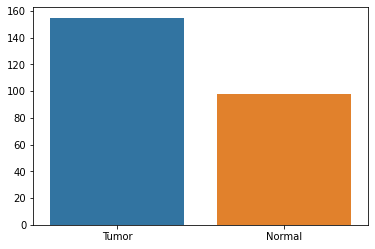

In [6]:
noTumor = len(os.listdir(input_path + '/no'))
yesTumor = len(os.listdir(input_path + '/yes'))

count = [yesTumor, noTumor]
label=['Tumor','Normal']

sns.barplot(label,count)

In [7]:
noTumor

98

In [8]:
yesTumor

155

Imamo 155 slika koje pokazuju tumor i 98 koje ne pokazuju tumor

In [11]:
def show_image(dir_path, folder, num):
    path = os.path.join(dir_path, folder)
    
    images = random.choices(os.listdir(path), k = num)
    images = [os.path.join(path, file) for file in images]
    
    return images

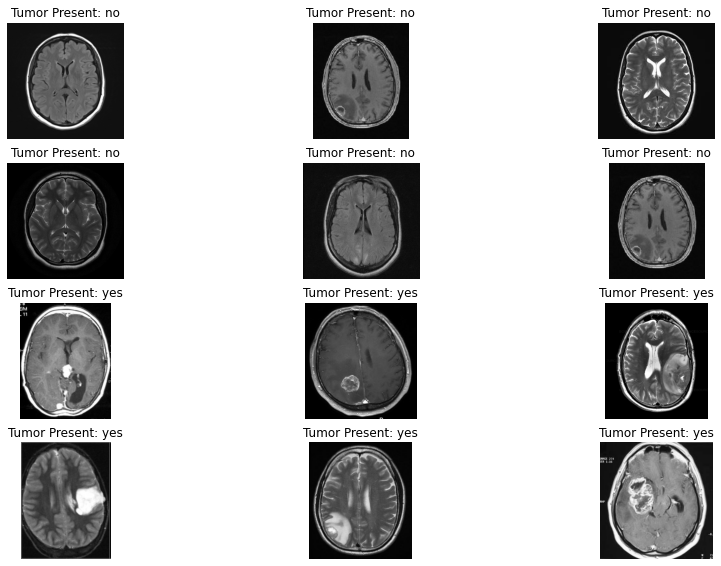

In [12]:
img1 = show_image(input_path, 'no', 6)
img2 = show_image(input_path, 'yes', 6)
label1 = ['no']*6
label2 = ['yes']*6

images = img1 + img2
labels = label1 + label2

plt.figure(figsize=(15,15))

for i,path_name in enumerate(images):
    plt.subplot(6,3,i+1)
    image = cv.imread(path_name)
    plt.imshow(image)
    plt.title("Tumor Present: " + labels[i])
    plt.axis('off')

## Priprema podataka

In [13]:
def load_data(dir_list):
    X = []
    y = []
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv.imread(directory + '/' + filename)

            X.append(image)
            # append a value of 1 to the y array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    return X, y

Za veliki broj slika možemo odseći deo slike gde koji zauzima samo crna površina.

In [14]:
import imutils

In [15]:
def crop_image(img, add_pixels_value=0, plot=False):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    gray = cv.GaussianBlur(gray, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv.threshold(gray, 45, 255, cv.THRESH_BINARY)[1]
    thresh = cv.erode(thresh, None, iterations=2)
    thresh = cv.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = add_pixels_value
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1] + ADD_PIXELS, extLeft[0]- ADD_PIXELS:extRight[0] + ADD_PIXELS].copy()
    
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_img)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_img

Primer slike:

In [16]:
img_test = cv.imread('brain_tumor_dataset/yes/Y29.jpg')
img_test = cv.resize(
            img_test,
            dsize=(224,224),
            interpolation=cv.INTER_CUBIC)

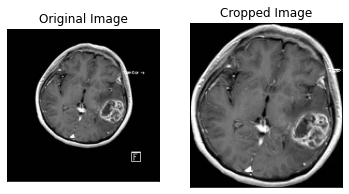

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)

In [17]:
crop_image(img_test,0,True)

In [18]:
def Croping_Data(images):
    X = []
    
    for img in images:
        image = crop_image(img, plot=False)
        X.append(image)
                
    X = np.array(X)
    
    return X

In [19]:
#load data
X_train_crop, y_train_crop = load_data([input_path + '/yes', input_path + '/no'])

In [20]:
#crop images
X_crop = Croping_Data(X_train_crop)

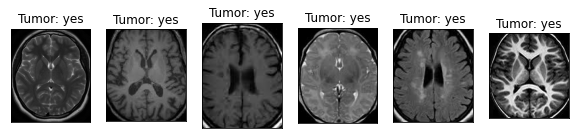

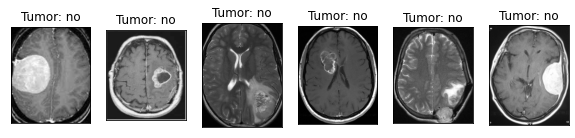

In [21]:
for index in range(len(['yes','no'])):
    imgs = X_crop[np.argwhere(y_train_crop == index)][:6]
    j = 6
    i = 1

    plt.figure(figsize=(10,10))
    c = 1
    for img in imgs:
        plt.subplot(i,j,c)
        plt.imshow(img[0])

        plt.xticks([])
        plt.yticks([])
        c += 1
        plt.title('Tumor: {}'.format(['yes','no'][index]))
    plt.show()

Sada trebamo sačuvati ove slike:

In [22]:
os.makedirs('output/cropped-images', exist_ok = True)
os.makedirs('output/cropped-images/yes', exist_ok = True)
os.makedirs('output/cropped-images/no', exist_ok = True)

cropped_data_path = 'output/cropped-images'

In [23]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv.imwrite(folder_name+'/no/'+ str(i) + 'no.jpg', img)
        else:
            cv.imwrite(folder_name+'/yes/'+ str(i) + 'yes.jpg', img)
        i += 1

In [24]:
dir = os.listdir('output/cropped-images/yes') 
#if folder doesn't exists
if len(dir) == 0:
    save_new_images(X_crop, y_train_crop, folder_name = cropped_data_path)
else:
    print(len(dir))

155


Pošto je broj slika mali, možemo povećati broj slika tako što ćemo primeniti slučajne transformacije nad njima kao što su slučajna horizontalna okretanja ili male slučajne rotacije

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Novi folder za smeštanje slika:

In [26]:
os.makedirs('output/augmented-images', exist_ok = True)
os.makedirs('output/augmented-images/yes', exist_ok = True)
os.makedirs('output/augmented-images/no', exist_ok = True)

augmented_data_path = 'output/augmented-images'

In [27]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in os.listdir(file_dir):
        image = cv.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [28]:
dir = os.listdir('output/augmented-images/yes') 
#if folder doesn't exists
if len(dir) == 0: 
    # augment data in cropped images folder 'yes'
    augment_data(file_dir = cropped_data_path + '/yes', n_generated_samples = 6, save_to_dir = augmented_data_path + '/yes')
    # augment data in cropped images folder 'no' 
    augment_data(file_dir = cropped_data_path +'/no', n_generated_samples = 9, save_to_dir = augmented_data_path + '/no')
else:
    print(len(dir))

1085


In [29]:
augmented_yes = augmented_data_path +'/yes'
augmented_no = augmented_data_path +'/no'

Učitavanje obrađenih slika:

In [30]:
X_train, y_train = load_data([augmented_yes, augmented_no])

In [31]:
y_train.size

2064

In [32]:
X_train.size

2064

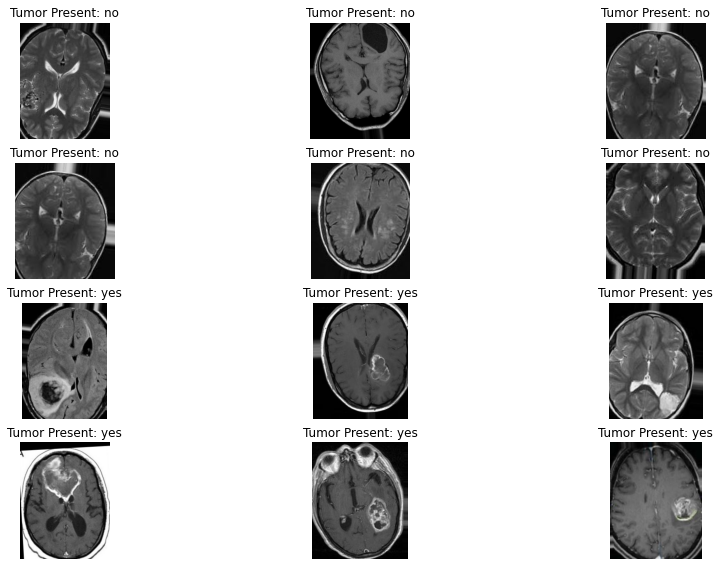

In [33]:
img1 = show_image(augmented_data_path, 'no', 6)
img2 = show_image(augmented_data_path, 'yes', 6)
label1 = ['no']*6
label2 = ['yes']*6

images = img1 + img2
labels = label1 + label2

plt.figure(figsize=(15,15))

for i,path_name in enumerate(images):
    plt.subplot(6,3,i+1)
    image = cv.imread(path_name)
    plt.imshow(image)
    plt.title("Tumor Present: " + labels[i])
    plt.axis('off')

Slikama se takođe treba promeniti veličina

In [69]:
def Resize_Data(train):
    X = []
    
    IMG_WIDTH, IMG_HEIGHT = (240, 240)
    
    for img in train:
        image = cv.resize(img, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation = cv.INTER_CUBIC)
        # normalize values
        image = image / 255.
        # convert image to numpy array and append it to X
        X.append(image)
                
    X = np.array(X)
    
    return X

In [35]:
X = Resize_Data(X_train)
y = y_train

Sada ovako obrađenim slikama možemo trenirati neuronsku mrežu

## Treniranje mreže

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report
from sklearn.model_selection import train_test_split

In [39]:
from sklearn.utils import shuffle 

In [40]:
#shuffle data
X, y = shuffle(X, y)

Dataset delimo na 3 podskupa, `train`, `test` i `validation`. `validation` podskup se koristi za podešavanje parametra, a `test` za evaluaciju performansi modela.

In [41]:
def split_data(X, y):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = 0.3, random_state = 42)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = 42)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [42]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

In [43]:
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of validation examples = " + str(X_val.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))

Number of training examples = 1444
Number of validation examples = 310
Number of test examples = 310


In [44]:
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D

In [56]:
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

In [58]:
def build_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4))(X) 
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [59]:
IMG_SHAPE = (240, 240, 3)
model = build_model(IMG_SHAPE)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)       

In [60]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
46/46 [==============================] - 94s 2s/step - loss: 0.9247 - accuracy: 0.5997 - val_loss: 0.6760 - val_accuracy: 0.5677
Epoch 2/22
46/46 [==============================] - 92s 2s/step - loss: 0.5976 - accuracy: 0.6953 - val_loss: 0.6274 - val_accuracy: 0.6613
Epoch 3/22
46/46 [==============================] - 96s 2s/step - loss: 0.5398 - accuracy: 0.7361 - val_loss: 0.6020 - val_accuracy: 0.6839
Epoch 4/22
46/46 [==============================] - 93s 2s/step - loss: 0.5558 - accuracy: 0.7258 - val_loss: 0.6497 - val_accuracy: 0.6065
Epoch 5/22
46/46 [==============================] - 94s 2s/step - loss: 0.4988 - accuracy: 0.7618 - val_loss: 0.5877 - val_accuracy: 0.6742
Epoch 6/22
46/46 [==============================] - 95s 2s/step - loss: 0.4322 - accuracy: 0.8054 - val_loss: 0.6829 - val_accuracy: 0.6000
Epoch 7/22
46/46 [==============================] - 93s 2s/step - loss: 0.4139 - accuracy: 0.8193 - val_loss: 0.6045 - val_accuracy: 0.6871
Epoch 8/22
46/46 [==

In [61]:
history = model.history.history

In [62]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

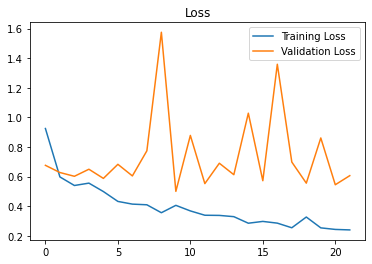

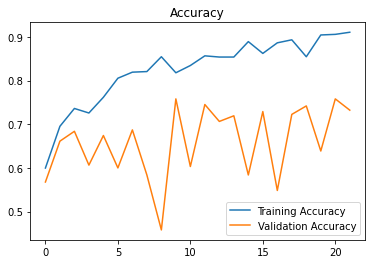

In [63]:
plot_metrics(history)

In [64]:
import itertools

In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Val Accuracy = 0.73


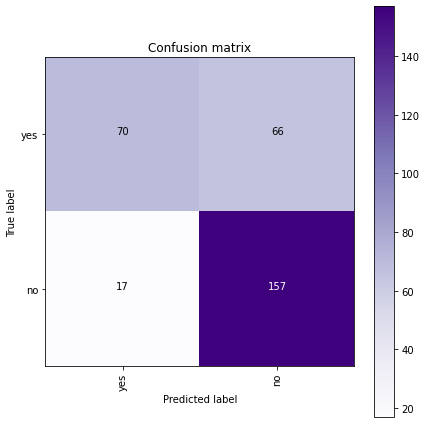

In [66]:
labels = ['yes','no']
# validation set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

Val Accuracy = 0.71


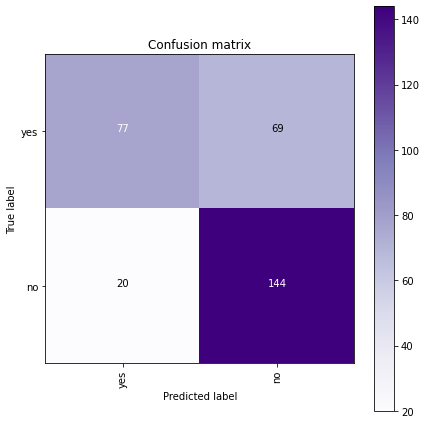

In [67]:
# test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

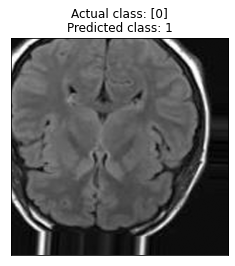

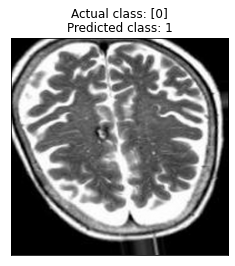

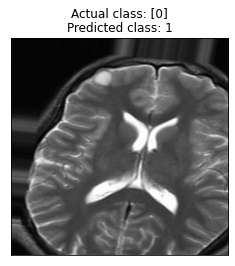

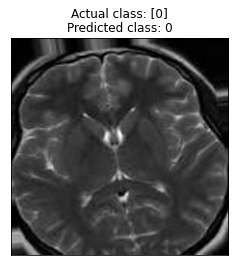

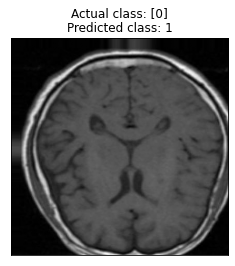

In [68]:
for i in range(5):
    plt.figure()
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')
    plt.show()